# Un0rick Anti Aliasing Filter


This notebook creates the plots for the un0rick anti aliasing filter, which is implemented between the VGA and the ADC as an differential filter. This notebook also compares the calculations with the spice simulations. It also attempts to verify the symbolic calculations with SymPy.


Run the next cell to load the required packages and functions.

In [235]:
from matplotlib_template import *
from scipy import signal
import sympy as sp
from IPython.display import display, Math
from math import pi
import numpy as np
import os.path as path
%matplotlib inline
#%matplotlib notebook

data_dir   = path.join('data','plot_un0rick_anti_aliasing_filter')
output_dir = path.join('output','plot_un0rick_anti_aliasing_filter')

def read_spice_output(file_name):
    f_vdb = []
    f_ph  = []
    vdb   = []
    ph    = []
    reading_vdb = False
    
    with open(file_name,'r') as file_reader:
        lines = file_reader.readlines()
     
    for line in lines:
        split_text = (' '.join(line.split())).split(' ')
        split_values = line.split('\t')
        if len(split_text) >= 3:
            if split_text[2].startswith('vdb'):
                reading_vdb = True
            elif split_text[2].startswith('cph'):
                reading_vdb = False

        if split_values[0].isnumeric():
            if reading_vdb:
                f_vdb.append(float(split_values[1]))
                vdb.append(float(split_values[2]))
            else:
                f_ph.append(float(split_values[1]))
                ph.append((float(split_values[2])) + pi)
                #ph.append((float(split_values[2]) * (180/pi)) + 180)
                
    return np.array(f_vdb), np.array(vdb), np.array(f_ph), np.array(ph)

## Defining The Filter Parameters:

In [236]:
# some metrics so that we can write i.e. C = 100*pF
nF   =  10**(-9)
pF   =  10**(-12)
nH   =  10**(-9)
pH   =  10**(-12)
MHz  = 10**(6)

# some metrics so that we can write i.e. plt.plot(f*display_MHz,y)
display_MHz = 10**(-6) 
display_ns  = 10**(9)

# electrical circuit
C1 = 100*nF
C2 = 100*pF
L1 = 100*nH
R1 = 100
R2 = 18

# transfer function parameters
y1 = L1
y0 = R1
x2 = C2 * L1 * (R1 + R2)
x1 = (C2 * R1 * R2) + ( ((C2/C1) + 1) * L1)
x0 = ((C2/C1) + 1) * R1

## Calculating The Transfer Function:

In [237]:
sys = signal.TransferFunction([y1, y0], [x2, x1, x0])

# w - angular frequency [rad/s], mag - magnutide [dB], ph_deg - phase [deg]
w, mag, ph_deg = signal.bode(sys, np.linspace(2*pi, 2*pi*150*MHz,  1000))  

f = w / (2*pi)          # frequency axis
ph = ph_deg * (pi/180)  # phase [-pi ... pi]

# Load the spice simulation data
f_vdb1, vdb1, f_ph1, ph1  = read_spice_output(path.join(data_dir, 'spice_out_single_ended.txt'))
f_vdb2, vdb2, f_ph2, ph2  = read_spice_output(path.join(data_dir,'spice_out_differential.txt'))

## Plot - Bode with calculation and spice simulation

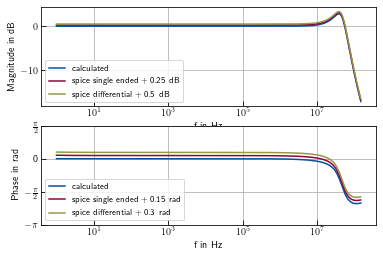

In [238]:
# Y-Axis Spacing
vdb_spacing1 = 0.25
vdb_spacing2 = 2*vdb_spacing1

ph_spacing1 = 0.15
ph_spacing2 = 2*ph_spacing1

fig, axs = plt.subplots(2,1)
    
# Plot Calculations
axs[0].semilogx(f, mag, color=color_palate[0])
axs[1].semilogx(f, ph, color=color_palate[0])

# Plot single ended simulation
axs[0].semilogx(f_vdb1, vdb1 + vdb_spacing1, color=color_palate[4])
axs[1].semilogx(f_ph1, ph1 + ph_spacing1, color=color_palate[4])

# Plot differential simulation
axs[0].semilogx(f_vdb2, vdb2 + vdb_spacing2, color=color_palate[1])
axs[1].semilogx(f_ph2, ph2 + ph_spacing2, color=color_palate[1])

# format magnitude plot
axs[0].grid(True,which='both')
axs[0].set_xlabel('f in Hz')
axs[0].set_ylabel('Magnitude in dB')

legend =  ['calculated']
legend += ['spice single ended + ' + str(vdb_spacing1) + ' dB']
legend += ['spice differential + ' + str(vdb_spacing2) + ' dB']
axs[0].legend(legend,fontsize='small')

# format phase plot
axs[1].grid(True,which='both')
axs[1].set_xlabel('f in Hz')
axs[1].set_yticks([-pi, -pi/2, 0, pi/2])
axs[1].set_yticklabels(['$-\\pi$','$-\\frac{\\pi}{2}$','0','$\\frac{\\pi}{2}$'])

axs[1].set_ylabel('Phase in rad')

legend =  ['calculated']
legend += ['spice single ended + ' + str(ph_spacing1) + ' rad']
legend += ['spice differential + ' + str(ph_spacing2) + ' rad']
axs[1].legend(legend,fontsize='small')

plt.savefig(path.join(output_dir, 'un0rick_aa_filter_bode.svg'))
plt.show()

## Calculate The Cutoff Frequency at -3dB:

In [239]:
f_c = 0
i = 0
while mag[i] > -3:
    f_c = f[i]
    i += 1

print('Cutoff frequency: ' + str(f_c*display_MHz) + ' MHz')

Cutoff frequency: 65.46546602902902 MHz


## Plot - Magnitude Near Cutoff Freqzency

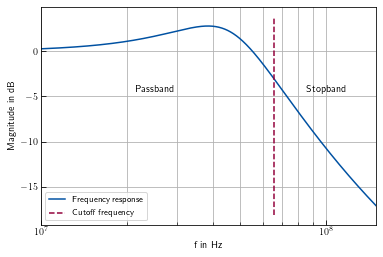

In [240]:
plt.semilogx(f, mag, color=color_palate[0])
plt.plot([f_c,f_c],plt.ylim(),linestyle='dashed',color=color_palate[4]) # vertical line at f_c

plt.xlim([10*MHz, 150*MHz]) # Zoom in

plt.grid(True,which='both')
plt.xlabel('f in Hz')
plt.ylabel('Magnitude in dB')

plt.text(25*MHz,  -4.5,'Passband',ha='center')
plt.text(100*MHz, -4.5,'Stopband',ha='center')
plt.legend(['Frequency response', 'Cutoff frequency'],fontsize='small')

plt.savefig(path.join(output_dir, 'un0rick_aa_filter_fresponse_mag_cutoff.svg'))
plt.show()                     

## Plot - Phase Delay:

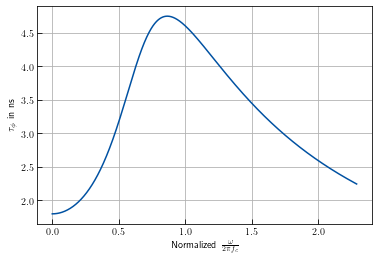

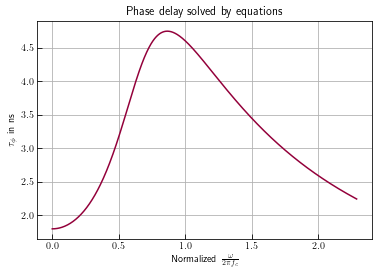

In [241]:
t_ph = (-ph)/w # phase delay

w_norm = w / (2*pi*f_c) # normalized w axis

plt.plot(w_norm, t_ph*display_ns,color=color_palate[0])
plt.grid(True,which='both')
plt.xlabel('Normalized $\\frac{\\omega}{2\\pi f_c}$')
plt.ylabel('$\\tau_{\\phi}$ in ns')

plt.savefig(path.join(output_dir, 'un0rick_aa_filter_phase_delay.svg'))
plt.show()

# Solving phase delay according to the equations as comparison:
atan1 = np.arctan2(w*x1, x0 - (w*w*x2))
atan2 = np.arctan2(w*y1, y0)
t_ph_eq = (atan1 - atan2)/w

plt.plot(w_norm, t_ph_eq*display_ns,color=color_palate[4])
plt.grid(True,which='both')
plt.xlabel('Normalized $\\frac{\\omega}{2\\pi f_c}$')
plt.ylabel('$\\tau_{\\phi}$ in ns')
plt.title("Phase delay solved by equations")
plt.show()

## Plot - Group Delay:



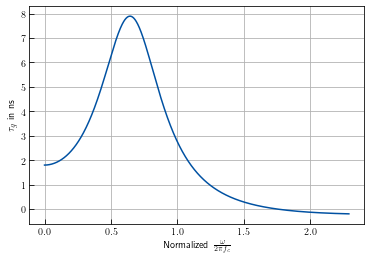

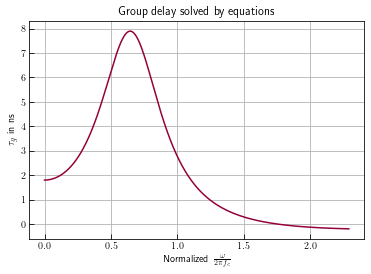

In [242]:
t_gr = np.zeros(len(w))
for i in range(len(w) - 1):
    t_gr[i] = (ph[i] - ph[i+1])/(w[i+1] - w[i])

t_gr[-1] = t_gr[-2] # to match the length of w

plt.plot(w_norm, t_gr*display_ns,color=color_palate[0])
plt.grid(True,which='both')
plt.xlabel('Normalized $\\frac{\\omega}{2\\pi f_c}$')
plt.ylabel('$\\tau_{g}$ in ns')

plt.savefig(path.join(output_dir, 'un0rick_aa_filter_group_delay.svg'))
plt.show()

# Solving group delay according to the equations as comparison:
frac1 = (y0 * y1) / ((w*w * y1*y1) + (y0*y0))
num_frac2 = x1 * ((w*w * x2) + x0)
den_frac2 = (w**4)*(x2**2) + (w*w*x1*x1) - (2*w*w*x0*x2) + (x0*x0)
frac2 = num_frac2 / den_frac2
t_gr_eq = frac2 - frac1

plt.plot(w_norm, t_gr_eq*display_ns,color=color_palate[4])
plt.grid(True,which='both')
plt.xlabel('Normalized $\\frac{\\omega}{2\\pi f_c}$')
plt.ylabel('$\\tau_{g}$ in ns')
plt.title("Group delay solved by equations")
plt.show()

## Symbolic solving

In [264]:
def symbolic_solving():
    sp.init_printing(use_latex='mathjax')
    C1, C2, L1, R1, R2 = sp.symbols('C1 C2 L1 R1 R2')
    s, Z1, Z2, Z3 = sp.symbols('s Z1 Z2 Z3')
    H1 = sp.Function('H1')
    H2 = sp.Function('H2')

    Z1 = (s*L1*R1) / (s*L1 + R1)
    Z2 = R2 + (1/(s*C1))
    Z3 = 1/(s*C2)

    display('Calculating Transfer Function with sympy:')
    display(Math('Z_1 = '+ sp.latex(Z1)))
    display(Math('Z_2 = '+ sp.latex(Z2)))
    display(Math('Z_3 = '+ sp.latex(Z3)))

    H1 = Z3/(Z1 + Z2 + Z3)
    display(Math('H_1(s) = '+ sp.latex(H1)))
    H1 = sp.simplify(H1)
    display(Math('H_1(s) = '+ sp.latex(H1)))

    display('Comparing with calculated Transfer Function:')
    y1 = L1
    y0 = R1
    x2 = C2 * L1 * (R1 + R2)
    x1 = (C2 * R1 * R2) + ( ((C2/C1) + 1) * L1)
    x0 = ((C2/C1) + 1) * R1

    display(Math('y_0 = '+ sp.latex(y0)))
    display(Math('y_1 = '+ sp.latex(y1)))
    display(Math('x_2 = '+ sp.latex(x2)))
    display(Math('x_1 = '+ sp.latex(x1)))
    display(Math('x_0 = '+ sp.latex(x0)))
    
    H2 = (s*y1 + y0)/(s**2*x2 + s*x1 + x0)
    display(Math('H_2(s) = '+ sp.latex(H2)))

    spacing = '\\,'*4
    display('Result:')
    display(Math('H_1(s) \\iff H_2(s) ' + spacing + 'is' + spacing + str(H1.equals(H2))))
    return

symbolic_solving()

'Calculating Transfer Function with sympy:'

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

'Comparing with calculated Transfer Function:'

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

'Result:'

<IPython.core.display.Math object>